### VQE on MaxCut
---

In [1]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx
import time

from qiskit import BasicAer
from qiskit.tools.visualization import plot_histogram
from qiskit.optimization.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance
from qiskit.optimization.ising.common import sample_most_likely

import logging
from qiskit.aqua import set_qiskit_aqua_logging

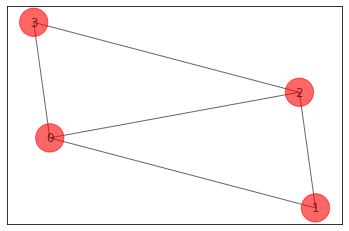

In [10]:
# generate a graph

n = 4
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
E = [(0,1,1.0),(0,2,1.0),(0,3,1.0),(1,2,1.0),(2,3,1.0)]
# E = [(0,1,2.0),(0,2,1.5),(0,3,1.0),(1,2,2.5),(2,3,1.0)]
G.add_weighted_edges_from(E)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=800, alpha=0.6, ax=default_axes, pos=pos)

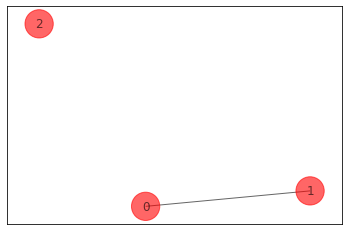

In [38]:
# generate a graph

n = 3
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
E = [(0,1,1.0)]
G.add_weighted_edges_from(E)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=800, alpha=0.6, ax=default_axes, pos=pos)

In [39]:
# build a weight matrix from G
w = np.zeros([n,n])
for i, j, data in G.edges.data():
    w[i][j] = data['weight']
    w[j][i] = data['weight']
print(w)

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 0.]]


#### Brute Force Algm
---

case = [0, 0, 0] cost = 0.0
case = [1, 0, 0] cost = 1.0
case = [0, 1, 0] cost = 1.0
case = [1, 1, 0] cost = 0.0
case = [0, 0, 1] cost = 0.0
case = [1, 0, 1] cost = 1.0
case = [0, 1, 1] cost = 1.0
case = [1, 1, 1] cost = 0.0

Best solution = [0, 1, 1] cost = 1.0 time taken: 0.02739s


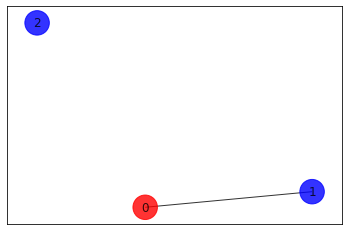

In [40]:
start = time.time()
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i,j]*x[i]*(1-x[j])
    if best_cost_brute <= cost:
        best_cost_brute = cost
        xbest_brute = x 
    print('case = ' + str(x)+ ' cost = ' + str(cost))

colors = ['r' if xbest_brute[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, pos=pos)
print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute) + ' time taken: {:.5f}s'.format(time.time()-start))

#### The Quantum Way
---

In [41]:
qubitOp, offset = max_cut.get_operator(w)

In [42]:
print(qubitOp)

Representation: paulis, qubits: 3, size: 1


energy: -0.5
max-cut objective: -1.0
solution: [0. 1. 1.]
solution objective: 1.0


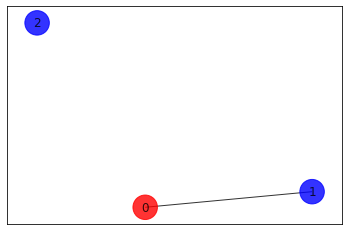

In [43]:
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))

colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

energy: -0.5
time: 8.1977379322052
max-cut objective: -1.0
solution: [0 1 1]
solution objective: 1.0


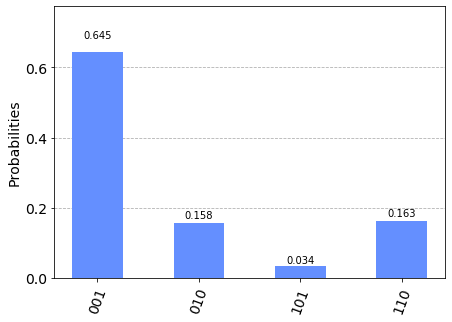

In [44]:
seed = 11860
optim = SPSA(max_trials=300)  # optimizer
ry = RY(qubitOp.num_qubits, depth=5, entanglement='linear')  # ansatz
vqe = VQE(qubitOp, ry, optim)

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)
x = sample_most_likely(result['eigvecs'][0])
print('energy:', result['energy'])
print('time:', result['eval_time'])
print('max-cut objective:', result['energy'] + offset)
print('solution:', max_cut.get_graph_solution(x))
print('solution objective:', max_cut.max_cut_value(x, w))
plot_histogram(result['eigvecs'][0])

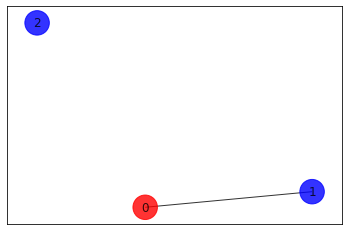

In [45]:
colors = ['r' if max_cut.get_graph_solution(x)[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha = .8, pos=pos)

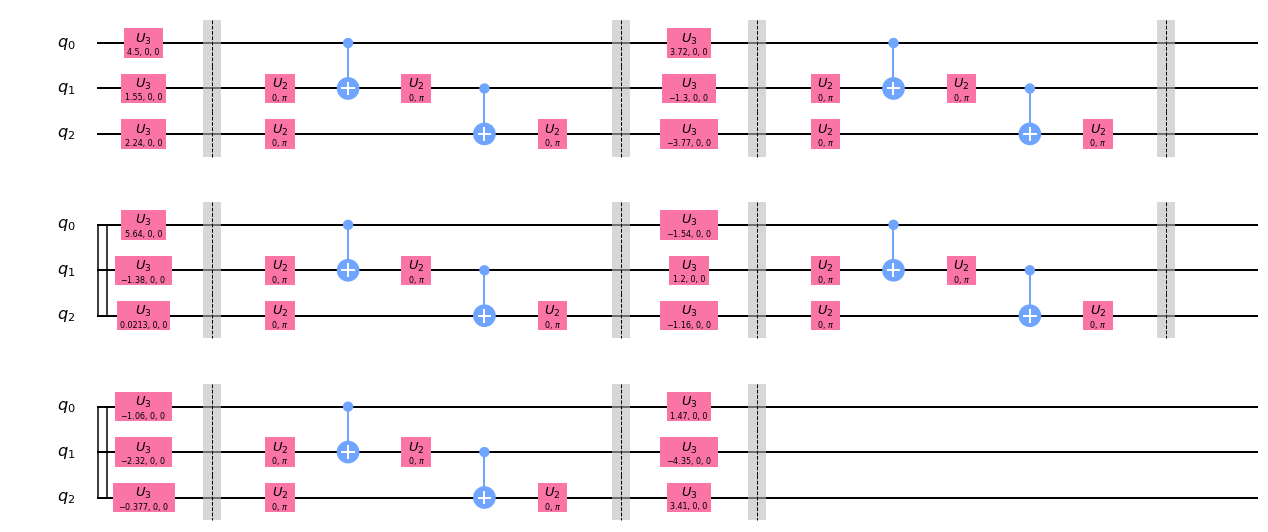

In [46]:
VQE.get_optimal_circuit(vqe).draw(output='mpl')

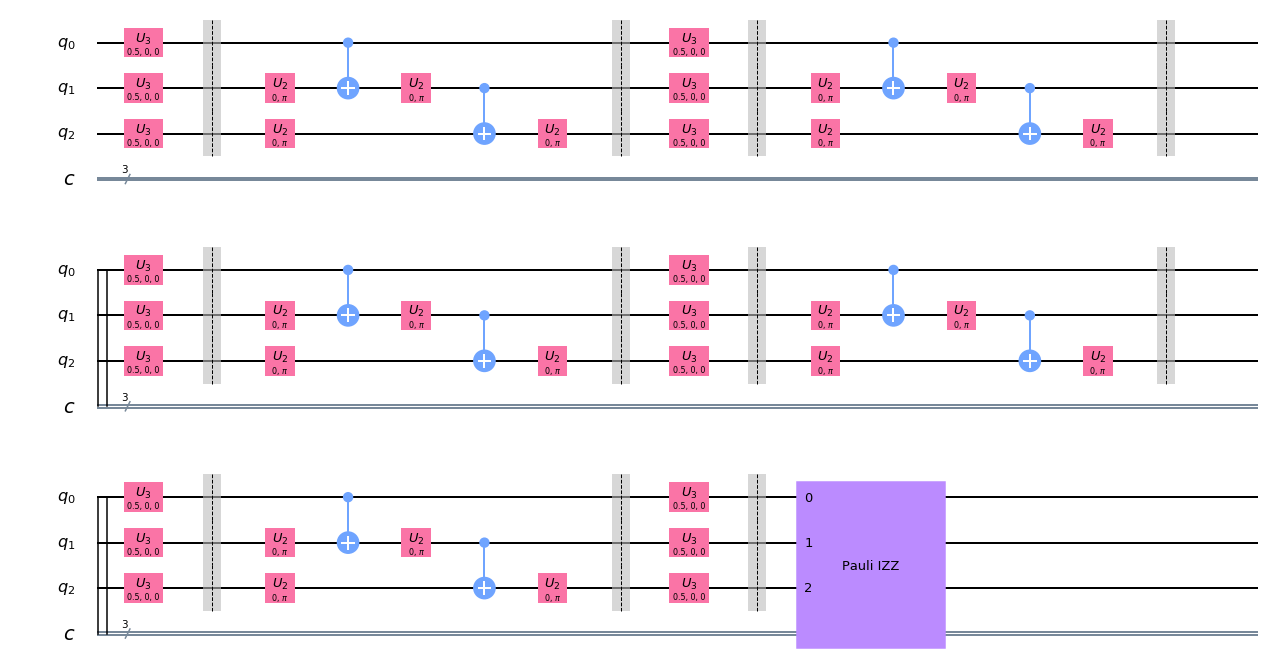

In [53]:
VQE.construct_circuit(vqe, [0.5]*18)[0].draw(output='mpl')